In [1]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from perturb import random_pres_wind_perturb

In [2]:
##define the grid (topaz) for perturbations
from grid import Grid
from models.topaz.v5 import read_grid

grid = read_grid('/cluster/work/users/yingyue/data/TP5')

In [ ]:
from models.topaz.abfile import ABFileForcing

path = '/cluster/work/users/yingyue/data/TP5_forcing'

nens = 10
rdtime = 0.25  ##days

ampl_pres = 300 ##Pa
ampl_wind = 3   ##m/s
scales_sig = [3, 12, 50]
scales_wgt = [1000, 10, 0.1]
tscale = 72 ##hours

##open original forcing file
fu0 = ABFileForcing(path+'/wndewd.a', 'r')
fv0 = ABFileForcing(path+'/wndnwd.a', 'r')
fp0 = ABFileForcing(path+'/mslprs.a', 'r')

dtime_list = np.sort(list(set(rec['dtime1'] for i,rec in fu0.fields.items())))

##open nens perturbed forcing files
for m in range(nens):
    mstr = '_mem{:03d}'.format(m+1)
    print('member ', m+1)

    fum = ABFileForcing(path+'/wndewd'+mstr+'.a', 'w', cline1=fu0._cline1, cline2=fu0._cline2)
    fvm = ABFileForcing(path+'/wndnwd'+mstr+'.a', 'w', cline1=fv0._cline1, cline2=fv0._cline2)
    fpm = ABFileForcing(path+'/mslprs'+mstr+'.a', 'w', cline1=fv0._cline1, cline2=fv0._cline2)

    ##loop over time steps
    for dtime in dtime_list:
        #print(datetime(1900, 1, 1) + dtime*timedelta(days=1))

        u0 = fu0.read_field('wndewd', dtime)
        v0 = fv0.read_field('wndnwd', dtime)
        p0 = fp0.read_field('mslprs', dtime)

        if dtime == dtime_list[0]:
            p, u, v = random_pres_wind_perturb(grid, rdtime*24, None, None, None,
                                               ampl_pres, ampl_wind, scales_sig, scales_wgt, tscale)
        else:
            p, u, v = random_pres_wind_perturb(grid, rdtime*24, p, u, v,
                                               ampl_pres, ampl_wind, scales_sig, scales_wgt, tscale)
        
        fum.write_field(u0+u, True, 'wndewd', dtime, rdtime)
        fvm.write_field(v0+v, True, 'wndnwd', dtime, rdtime)
        fpm.write_field(p0+p, True, 'mslprs', dtime, rdtime)

    fum.close()
    fvm.close()
    fpm.close()

##close original forcing file
fu0.close()
fv0.close()
fp0.close()


member  1
member  2
member  3
member  4
member  5
member  6
member  7
member  8
member  9
member  10


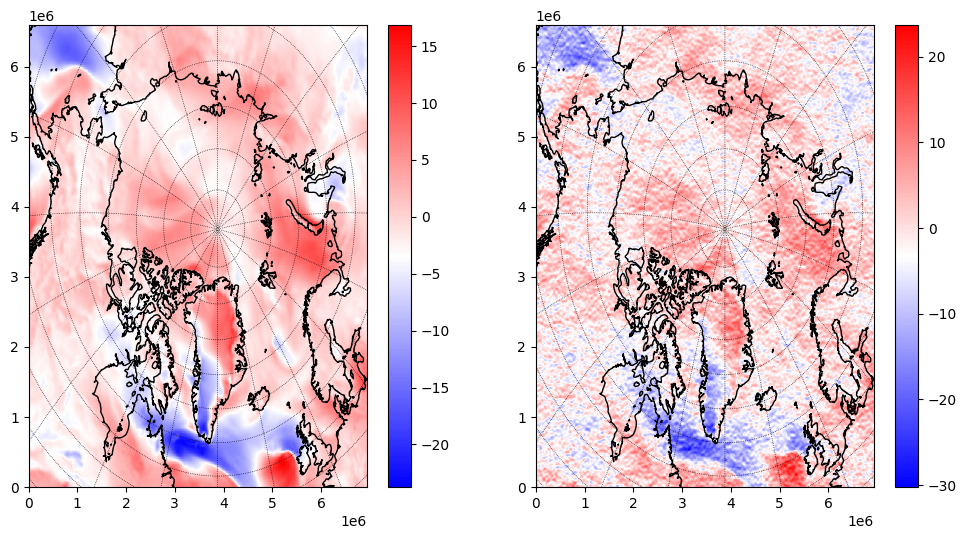

In [132]:
##read field and plot
dtime = 43953.0 + 1*0.25

f0 = ABFileForcing(path+'/wndewd.a', 'r')
u0 = f0.read_field('wndewd', dtime)
f = ABFileForcing(path+'/wndewd_mem001.a', 'r')
u = f.read_field('wndewd', dtime)
f.close()
f0.close()

fig, ax = plt.subplots(1, 2, figsize=(12,5))

im = grid.plot_field(ax[0], u0, cmap='bwr')
plt.colorbar(im)
grid.plot_land(ax[0], color='gray')

im = grid.plot_field(ax[1], u, cmap='bwr')
plt.colorbar(im)
grid.plot_land(ax[1], color='gray')


In [126]:
###Testing perturbation generator
pres, u, v = random_pres_wind_perturb(grid,
                                      6,                        ##dt, hours
                                      None, None, None,         ##previous pres, u, v
                                      300, 3,                 ##amplitudes for pres (Pa), wind (m/s) (std of pert)
                                      [3, 20, 50], [1000, 1, 0], ##scales_sig, scale_wgt
                                      72,                       ##time decorrelation scale, hours
                                      True,                     ##pres_wind_relate
                                      15.                       ##wlat
                                     )

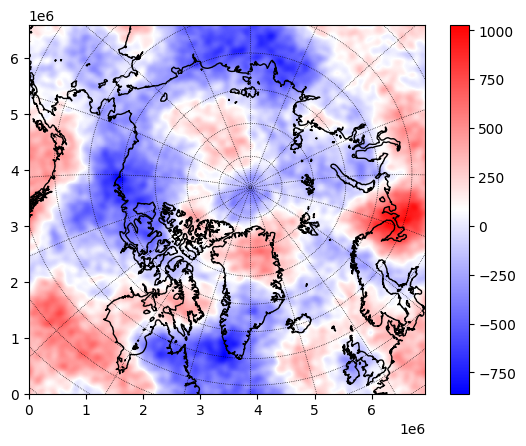

In [129]:
###visualize field
fig, ax = plt.subplots(1,1)
#grid.plot_vectors(ax, np.array([u, v]))
#im = grid.plot_field(ax, pres, cmap='bwr')
im = grid.plot_field(ax, u, cmap='bwr')
plt.colorbar(im)
grid.plot_land(ax, color='gray')

(0.0001, 100.0)

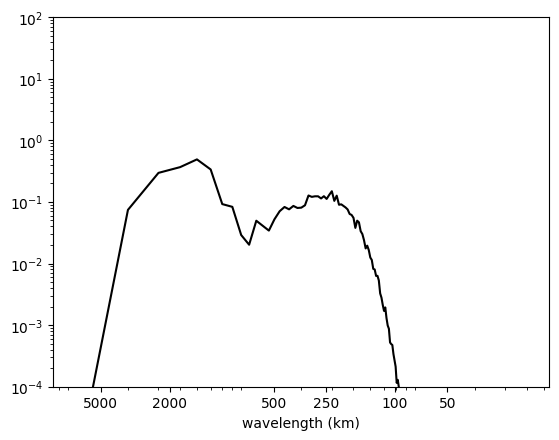

In [128]:
##### visualize spectrum
from diag import pwrspec2d

fig, ax = plt.subplots(1,1)

##wavenumber and power spectrum of given field
wn, pwr = pwrspec2d(u)

##wavelength to display
L = grid.nx*grid.dx ##domain length (longer side)
wl1 = np.array([5000, 2000, 500, 250, 100, 50])
wn1 = L/1e3/wl1

ax.loglog(wn, pwr, color='k')

ax.set_xticks(wn1)
ax.set_xticklabels(wl1)

ax.set_xlabel('wavelength (km)')
ax.set_ylim(1e-4, 1e2)